<a href="https://colab.research.google.com/github/danielthomas06/Food101---DeepLearning/blob/main/06_Transfer_Learning_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up

We'll be using all the food classes in Food101. Our goal is to beat the original FOod101 paper with 10% data.

Our baseline to beat is 50.76% across 101 food classes


In [ ]:
!nvidia-smi

Wed Jul  7 17:50:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've create a series of helper function to do different functions.



In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-07 17:50:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-07 17:50:59 (88.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import series of helper functions for notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir,compare_historys, make_confusion_matrix

In [ ]:
## 101 Food Classes: working with less data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-07-07 17:51:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   216MB/s    in 6.9s    

2021-07-07 17:51:09 (224 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
#How many images classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/greek_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_

In [ ]:
#setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False )#Dont shuffle test data for prediction

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer laerning on 10% of 101 food classes.

Here are the steps we're going to take:
* Create ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) Functional EfficientNetB0 backbones-ModelCheckpoint
* Compile the model
* Feature extract for 5 full passes 

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data_augmentation 
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2)
], name="data_augmentaion")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_shape")
x = data_augmentation(inputs) #augment images(only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which needs to remain frozen remains frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
#Summary of model created
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentaion (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_pool_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
#Compiling the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fitting the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                    epochs=5, #to keep experiments faster
                    validation_data = test_data,
                    validation_steps = int(0.15 * len(test_data)),
                    callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 122s 369ms/step - loss: 3.4858 - accuracy: 0.2424 - val_loss: 2.7618 - val_accuracy: 0.3480
Epoch 2/5
237/237 [==============================] - 73s 306ms/step - loss: 2.3489 - accuracy: 0.4644 - val_loss: 2.2686 - val_accuracy: 0.4354
Epoch 3/5
237/237 [==============================] - 67s 281ms/step - loss: 1.9886 - accuracy: 0.5298 - val_loss: 2.0950 - val_accuracy: 0.4653
Epoch 4/5
237/237 [==============================] - 64s 267ms/step - loss: 1.7689 - accuracy: 0.5744 - val_loss: 2.0564 - val_accuracy: 0.4648
Epoch 5/5
237/237 [==============================] - 59s 248ms/step - loss: 1.5970 - accuracy: 0.6086 - val_loss: 1.9565 - val_accuracy: 0.4841


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 90s 114ms/step - loss: 1.7120 - accuracy: 0.5542


[1.712040662765503, 0.5541782379150391]

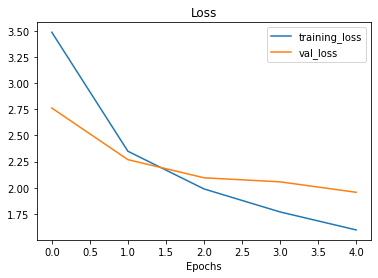

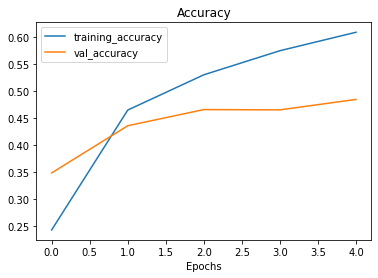

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

The plots above indicates the model overfits the training data. Both the training and validation curves need to go side by side.

Need to reduce overfitting

###Fine Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

#Refreeze every layer except the last 5 layer since layers closer to input detects larger features compared to last layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_shape True
data_augmentaion True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
#CHeck which layers are trainable in base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 #total number of epochs
#Fine_tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 67s 254ms/step - loss: 1.3754 - accuracy: 0.6385 - val_loss: 1.9419 - val_accuracy: 0.4889
Epoch 6/10
237/237 [==============================] - 56s 235ms/step - loss: 1.2577 - accuracy: 0.6669 - val_loss: 1.8963 - val_accuracy: 0.4997
Epoch 7/10
237/237 [==============================] - 54s 228ms/step - loss: 1.1598 - accuracy: 0.6920 - val_loss: 1.8645 - val_accuracy: 0.5072
Epoch 8/10
237/237 [==============================] - 54s 226ms/step - loss: 1.0799 - accuracy: 0.7090 - val_loss: 1.8592 - val_accuracy: 0.5140
Epoch 9/10
237/237 [==============================] - 54s 226ms/step - loss: 1.0033 - accuracy: 0.7328 - val_loss: 1.8690 - val_accuracy: 0.5124
Epoch 10/10
237/237 [==============================] - 52s 219ms/step - loss: 0.9694 - accuracy: 0.7459 - val_loss: 1.8383 - val_accuracy: 0.5201


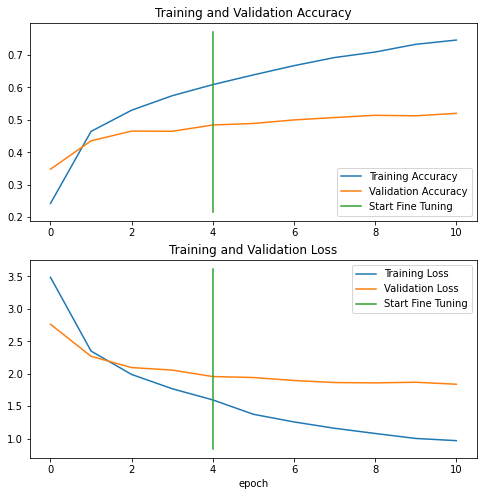

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# Saving and Loading our model
TO use our model in an external application, we'll need to save it and export it.

In [ ]:
# Save our model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_dog_model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_dog_model/assets


In [ ]:
#Load model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_dog_model")

## Making prediction with our trained model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) #Set verbosity true to see how long it takes to evaluate

790/790 [==============================] - 63s 78ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
preds_probs[:10]

array([[7.5178152e-01, 9.1202910e-06, 1.4659274e-02, ..., 4.6628800e-05,
        5.6347920e-04, 5.4708175e-02],
       [9.1084647e-01, 4.6382219e-08, 1.9559779e-03, ..., 1.6840402e-03,
        2.6339262e-07, 1.5354424e-06],
       [5.1339298e-01, 1.7119097e-03, 5.6951498e-03, ..., 7.7957916e-04,
        2.1863836e-03, 2.0606939e-03],
       ...,
       [7.2644997e-01, 4.1321282e-06, 1.2284121e-03, ..., 3.4105763e-02,
        2.6986614e-04, 8.2092789e-05],
       [2.4812213e-01, 1.6548591e-04, 3.8866103e-02, ..., 7.7410345e-04,
        9.4337032e-05, 4.6747384e-04],
       [5.7623196e-01, 1.4115642e-06, 8.0228376e-04, ..., 1.4414422e-02,
        7.0489086e-06, 4.4989302e-03]], dtype=float32)

Our model outputs a prediction probability array with 101 probability classes.

In [ ]:
# We get one prediction probability per class (In this example we get 101 prediction probabilites)
print(f"The class with the highes predicted probability by the model for sample 0:{preds_probs[0].argmax()}")

The class with the highes predicted probability by the model for sample 0:0


In [ ]:
test_data.class_names[0]

'apple_pie'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([ 0,  0,  0,  8, 29, 78, 29,  0,  9,  0])

In [ ]:
#Unbatch test_data so that we can compare our prediction and correct label
y_label = []
for images, label in test_data.unbatch():
  y_label.append(label.numpy().argmax())
y_label[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
pred_classes[:30]

array([  0,   0,   0,   8,  29,  78,  29,   0,   9,   0,   0,  67,  43,
         8,  67,   0,   8,  36,  57,   8,   2,  52, 100,   8,  72,  72,
        57,  31,   9,  79])

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test_data is to find the accuracy

In [ ]:
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_label,
                                  y_pred = pred_classes)

sklearn_accuracy

0.5775049504950495

In [ ]:
acc = model.evaluate(test_data)

790/790 [==============================] - 89s 113ms/step - loss: 1.6019 - accuracy: 0.5775


In [ ]:
acc[1] == sklearn_accuracy

False

##Let's get visual: making a confusion matrix

In [ ]:
class_names = test_data.class_names

In [ ]:
make_confusion_matrix(y_true=y_label,
                      y_pred=pred_classes,
                      figsize=(200,200),
                      classes=class_names,
                      text_size=30)

##Let's keep the evaluation with classsification report

Scikit learn has function precision, recall and F1 and classification_report


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_label,
                            y_pred = pred_classes))
                            

              precision    recall  f1-score   support

           0       0.23      0.21      0.22       250
           1       0.59      0.67      0.63       250
           2       0.69      0.52      0.60       250
           3       0.88      0.40      0.55       250
           4       0.51      0.40      0.45       250
           5       0.36      0.43      0.39       250
           6       0.70      0.79      0.74       250
           7       0.79      0.76      0.77       250
           8       0.24      0.56      0.33       250
           9       0.40      0.56      0.47       250
          10       0.52      0.43      0.47       250
          11       0.75      0.56      0.64       250
          12       0.64      0.62      0.63       250
          13       0.51      0.52      0.51       250
          14       0.60      0.39      0.47       250
          15       0.34      0.38      0.35       250
          16       0.67      0.50      0.57       250
          17       0.39    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_label, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.21987315010570826,
  'precision': 0.23318385650224216,
  'recall': 0.208,
  'support': 250},
 '1': {'f1-score': 0.6268656716417911,
  'precision': 0.5874125874125874,
  'recall': 0.672,
  'support': 250},
 '10': {'f1-score': 0.47136563876651977,
  'precision': 0.5245098039215687,
  'recall': 0.428,
  'support': 250},
 '100': {'f1-score': 0.6210720887245841,
  'precision': 0.5773195876288659,
  'recall': 0.672,
  'support': 250},
 '11': {'f1-score': 0.6438356164383561,
  'precision': 0.75,
  'recall': 0.564,
  'support': 250},
 '12': {'f1-score': 0.631578947368421,
  'precision': 0.639344262295082,
  'recall': 0.624,
  'support': 250},
 '13': {'f1-score': 0.5149700598802395,
  'precision': 0.5139442231075697,
  'recall': 0.516,
  'support': 250},
 '14': {'f1-score': 0.47342995169082125,
  'precision': 0.5975609756097561,
  'recall': 0.392,
  'support': 250},
 '15': {'f1-score': 0.3547169811320754,
  'precision': 0.3357142857142857,
  'recall': 0.376,
  'support': 25

Let's plot all of our classes F1-scores.. 

In [ ]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    #add class names and f1_scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.21987315010570826,
 'baby_back_ribs': 0.6268656716417911,
 'baklava': 0.5954545454545455,
 'beef_carpaccio': 0.5454545454545454,
 'beef_tartare': 0.4469525959367946,
 'beet_salad': 0.3883847549909256,
 'beignets': 0.7392120075046904,
 'bibimbap': 0.7739307535641547,
 'bread_pudding': 0.33214709371293005,
 'breakfast_burrito': 0.4690117252931324,
 'bruschetta': 0.47136563876651977,
 'caesar_salad': 0.6438356164383561,
 'cannoli': 0.631578947368421,
 'caprese_salad': 0.5149700598802395,
 'carrot_cake': 0.47342995169082125,
 'ceviche': 0.3547169811320754,
 'cheese_plate': 0.5701149425287357,
 'cheesecake': 0.39999999999999997,
 'chicken_curry': 0.4517647058823529,
 'chicken_quesadilla': 0.6028708133971292,
 'chicken_wings': 0.7212475633528265,
 'chocolate_cake': 0.5206896551724137,
 'chocolate_mousse': 0.35502958579881655,
 'churros': 0.7198443579766536,
 'clam_chowder': 0.6849894291754757,
 'club_sandwich': 0.6842105263157895,
 'crab_cakes': 0.3434343434343434,
 'creme_br

In [ ]:
# Turn f1-scores into Dataframe for visualisation
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)


In [ ]:
f1_scores

class_names  f1_score
33        edamame  0.962525
75            pho  0.843137
63       macarons  0.842572
45  frozen_yogurt  0.825726
32      dumplings  0.812379
..            ...       ...
99   tuna_tartare  0.322222
39      foie_gras  0.318538
77      pork_chop  0.317269
93          steak  0.291913
0       apple_pie  0.219873

[101 rows x 2 columns]

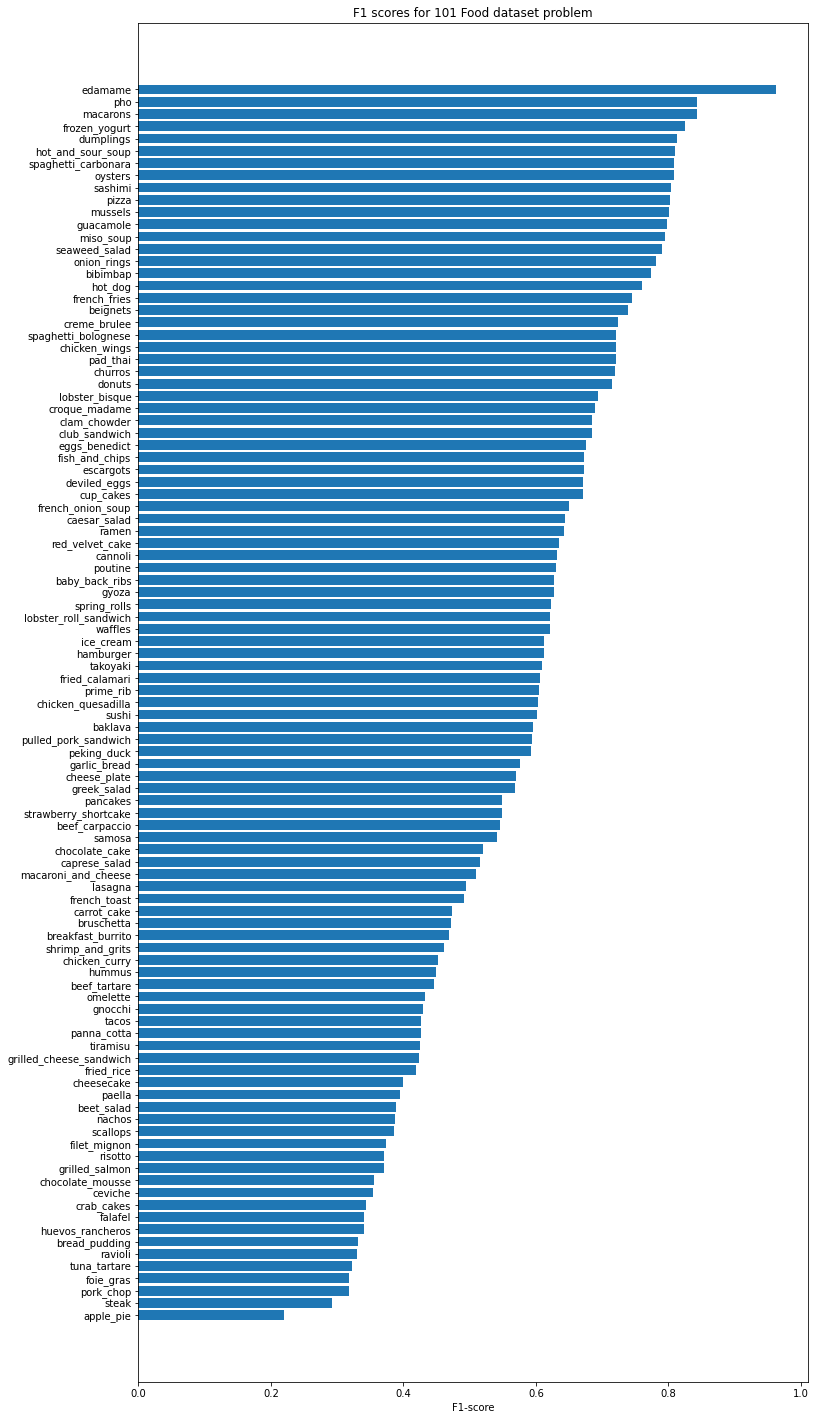

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 scores for 101 Food dataset problem")
ax.invert_yaxis()

## Visualising images not even in our test dataset (images of our own).

TO visualise our model's predictions on our own images, we'll need a function to load and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* resize the image tensor to be the same size as the images our model has trained on using tf.rescale
* Scale the image to get all of the pixel values between 0 and 1

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  read in an image from filename, and turns it intoa tensor and reshapes into speicfied shape( IMg_shape, img_shape, color_channels=3).

  Args:
  filename (str): path to target image
  image_shape (int): height/wight dimension of the image
  scale (bool) : scale pixel values from 0-255 or 0-1 or not

  Returns:
  Image tensor of shape (img_shape, img_shape, 3)

  """
  #Read the image
  img = tf.io.read_file(filename)

  #Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  #Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  #Scale? Yes/No
  if scale:
    return img/255.
  else:
    return img



Now we've got a function to load and prepare target images, let's now write code to visualize images, their target label and our model's predictions and probability

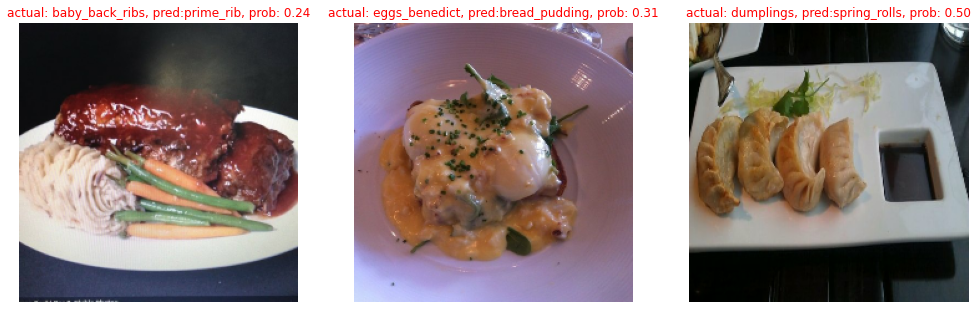

In [ ]:
#Make preds on a series of random images
import os
import random
plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" +class_name))
  filepath = test_dir + class_name +"/" + filename
  
  #load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img,axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()] #get the highest prediction probability index
  #print(pred_class)
  #print(pred_prob)

  #Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: #if predicted class matches truth class, text in green
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"actual: {class_name}, pred:{pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong predictions

To find out where our model is most wrong
1. Get all of the image file paths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes, max prediction probabilities
3. Use our DataFrame to find all the wrong predictions(where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wron predictions (have the highest prediction probability predictions at the top).
5. Visualise the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# Get all of the image file paths in the test data
filepaths= []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                    shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]


[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
#2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path" : filepaths,
                       "y_true": y_label,
                       "y_pred": pred_classes,
                       "pred_conf": preds_probs.max(axis=1),
                       "y_true_classname": [class_names[i] for i in y_label],
                       "y_pred_classname": [class_names[i] for i in pred_classes]})

pred_df

img_path  ...  y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...         apple_pie
1      b'/content/101_food_classes_10_percent/test/ap...  ...         apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...         apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...     bread_pudding
4      b'/content/101_food_classes_10_percent/test/ap...  ...         cup_cakes
...                                                  ...  ...               ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...           waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...      cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...           waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...           waffles
25249  b'/content/101_food_classes_10_percent/test/wa...  ...           waffles

[25250 rows x 6 columns]

In [ ]:
#3. Find out in our dataframe which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...          True
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [ ]:
#4. Sort our dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
15826  b'/content/101_food_classes_10_percent/test/ma...  ...         False
5652   b'/content/101_food_classes_10_percent/test/ch...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
22511  b'/content/101_food_classes_10_percent/test/sp...  ...         False
8767   b'/content/101_food_classes_10_percent/test/es...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
5892   b'/content/101_food_classes_10_percent/test/ch...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
22203  b'/content/101_food_classes_10_percent/test/se...  ...         False
11041  b'/content/101_food_classes_10_percent/test/fr...  ...         False
11974  b'/content/101_food_classes_10_percent/test/gn...  ...         False
21216  b'/content/101_food_classes_10_percent/test/ri...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
8076   b'/content/101_food_classes_10_percent/test/du...  ...         False
9110   b'/content/101_food_classes_10_percent/test/fa...  ...         False
21913  b'/content/101_food_classes_10_percent/test/sc...  ...         False
22684  b'/content/101_food_classes_10_percent/test/sp...  ...         False
15425  b'/content/101_food_classes_10_percent/test/lo...  ...         False

[20 rows x 7 columns]

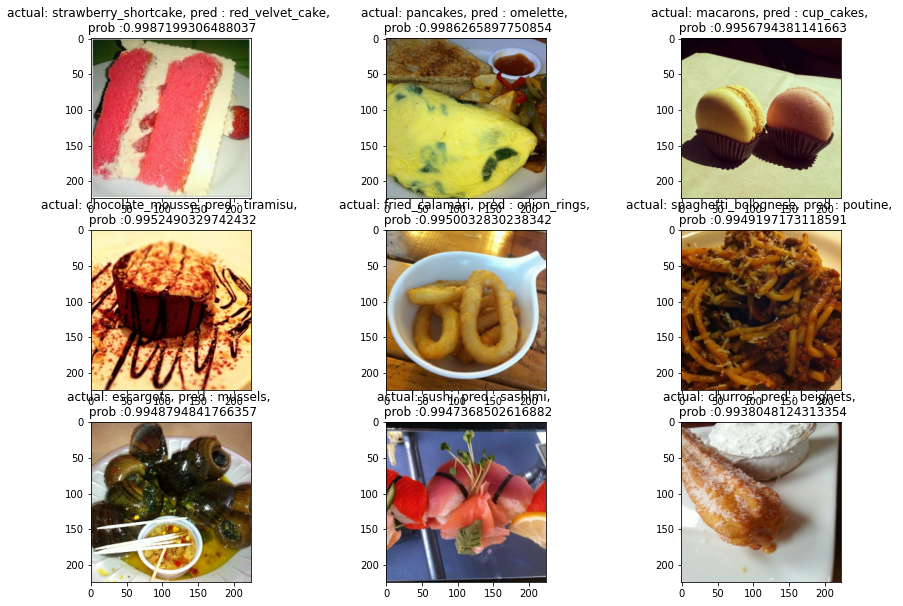

In [ ]:
#5. VIsualise the test data samples which have highest probability but have wrong prediction
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _= row 
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred : {y_pred_classname}, \n prob :{pred_prob}")

In [ ]:

# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2021-07-07 19:26:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  46.8MB/s    in 0.3s    

2021-07-07 19:26:04 (46.8 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/hamburger.jpeg']

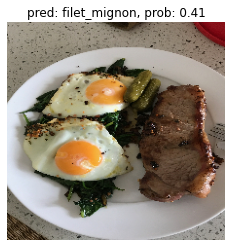

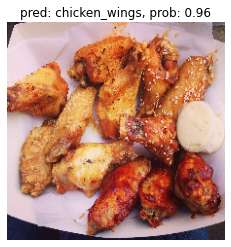

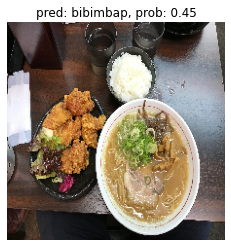

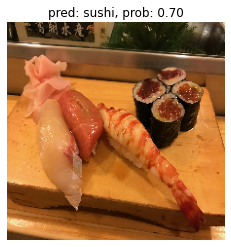

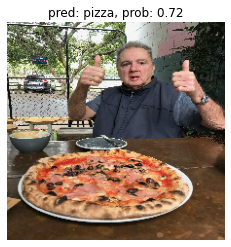

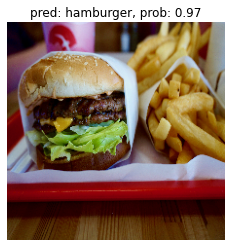

In [ ]:

# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)